In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import f_oneway

Filter the categorical variables

In [17]:
# Read data
data = pd.read_csv('../data/2.1_Train_Data_Sumed_For_Process.csv')

# Preprocess the data
# Apply one-hot encoding to categorical features
categorical_features = ['date', 'district', 'zip code', 'city']

# Save the list of categorical variables with p-value less than 0.05
new_categorical_features = []

# Using ANOVA to calculate the correlation
# For each categorical variable, calculate the ANOVA F-value and p-value with the numerical target variable
for feature in categorical_features:
    group = data.groupby(feature)["total cost"].apply(list)
    f, p = f_oneway(*group)
    if p < 0.05 and f > 40:
        new_categorical_features.append(feature)
        print(f"Feature {feature}, F-value: {f:.2f}, p-value: {p:.4f}")
        
# Preserve strongly correlated categorical features
new_data = data[new_categorical_features]

Feature zip code, F-value: 42.82, p-value: 0.0000
Feature city, F-value: 47.91, p-value: 0.0000


Filter the numerical variables

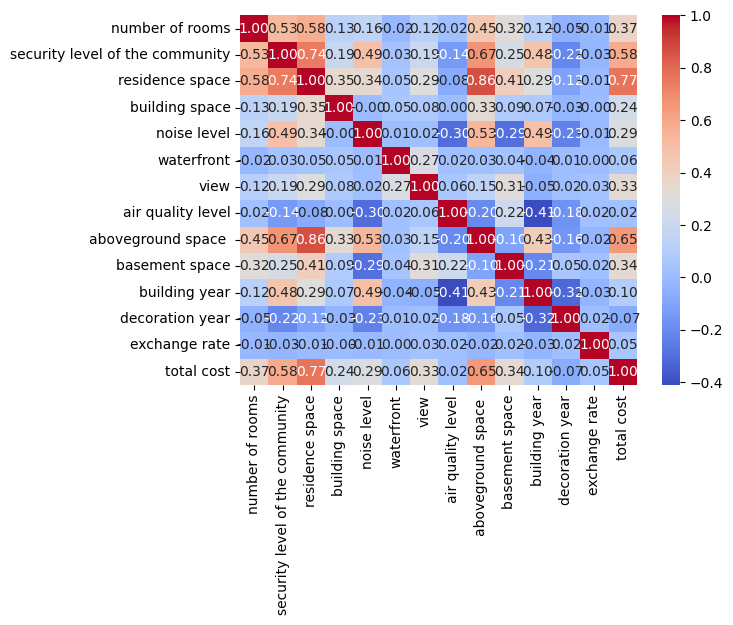

The related numerical variables and total cost:
['number of rooms', 'security level of the community', 'residence space', 'aboveground space ', 'noise level', 'building year', 'total cost']


In [18]:
# Get the column names of all non-categorical features
numerical_features = [col for col in data.columns if col not in categorical_features + ["total cost"]]

# Keep only numeric variables and target variables
numerical_data = data[numerical_features + ["total cost"]]

corr_matrix = numerical_data.corr(method='pearson', numeric_only = True)

# Draw a heat map...
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

# Save the correlation coefficient matrix as a CSV file
corr_matrix.to_csv('../data/2.2_Correlation_Matrix.csv')

# Calculate the correlation between each variable and "total cost"
corr = data.corr(method = "spearman", numeric_only = True)['total cost']

# Filter variables with an absolute value of correlation greater than or equal to 0.35
significant_vars = corr[(abs(corr) >= 0.35) & (corr.index != 'total cost')].index.tolist()

# Find variables other than significant_vars that have a correlation greater than 0.4 with any variable in significant_vars
##var1: other vars, var2: significant_vars
for var1 in data.columns:
    if var1 not in significant_vars and var1 != "district" and var1 != "city" and var1 != "zip code" and var1 != "date":
        for var2 in significant_vars:
            corr_value = data.corr(method='spearman', numeric_only = True).loc[var1, var2]
            if abs(corr_value) > 0.4:
                significant_vars.append(var1)
                break
    
# Print the significant values
print("The related numerical variables and total cost:")
print(significant_vars)

In [19]:
new_numerical_data = data[significant_vars]
# Using concat() to splice two data frames together by columns, where axis=1 means splicing by columns
new_data = pd.concat([new_data, new_numerical_data], axis=1)

# Save the result
print(new_data)

# Save the result
new_data.to_csv('../data/2.3_Correlation_Data_Sumed.csv', index=False)

      zip code        city  number of rooms  security level of the community  \
0     WA 98029    Issaquah                5                             2.50   
1     WA 98106     Seattle                2                             1.00   
2     WA 98001      Auburn                4                             2.50   
3     WA 98042        Kent                3                             1.50   
4     WA 98198  Des Moines                3                             1.75   
...        ...         ...              ...                              ...   
3995  WA 98014   Carnation                4                             3.50   
3996  WA 98004    Bellevue                5                             2.00   
3997  WA 98075   Sammamish                4                             2.50   
3998  WA 98126     Seattle                6                             2.50   
3999  WA 98024   Fall City                5                             4.25   

      residence space  aboveground spac

Save the new file with only related variables for training

In [20]:
# Read the data
data = pd.read_csv('../data/2.3_Correlation_Data_Sumed.csv')

# Define the classifier of total cost, to cost rank
def classify_total_cost(total_cost):
    if total_cost >= 0 and total_cost < 300000:
        return 1
    elif total_cost >= 300000 and total_cost < 500000:
        return 2
    elif total_cost >= 500000 and total_cost < 700000:
        return 3
    else:
        return 4

# Apply a categorical function and add a new column
data['cost rank'] = data['total cost'].apply(lambda x: classify_total_cost(x))
# delete the total cost variable
data.drop(['total cost'], axis=1, inplace=True)

# Save
data.to_csv('../data/2.4_Train_Data_New.csv', index=False)
selected_columns = data.columns.tolist()
selected_columns.remove('cost rank')
print(selected_columns)

# Read the test data and save it in the new file.
test_data = pd.read_csv('../data/Test_Data.csv')
new_test_data = test_data[selected_columns]
new_test_data['cost rank'] = ""
new_test_data.to_csv('../data/2.4_Test_Data_New.csv', index=False)

['zip code', 'city', 'number of rooms', 'security level of the community', 'residence space', 'aboveground space ', 'noise level', 'building year']


C:\Users\WangHaoyu\AppData\Local\Temp\ipykernel_17332\1525224675.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_data['cost rank'] = ""


After preprocess, we can build the model and training the model

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [22]:
# Dataset && DataLoader
class HouseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)  # Convert sparse matrix to dense
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Network structure

In [23]:
# PyTorch
class Net(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.15, l2_reg=0.00):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout_prob)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(dropout_prob)

        self.fc5 = nn.Linear(32, output_size)

        self.l2_reg = l2_reg ## Adjust the value of l2_reg to find the suitable parameter
    # Function: Relu(), using 0.15 dropout in every layer to reduce fit
    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x

    def l2_regularization(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2) ** 2
        return self.l2_reg * l2_loss

Hot code the categorical variables and preprocess data

In [24]:
def preprocess_data(train_data, test_data):
    # Preprocessing filtered categorical feature variables
    # In Preprocess.py, we find zip code and city are strongly related to cost rank
    categorical_features = ['zip code', 'city']
    numerical_features = [col for col in train_data.columns if col not in categorical_features + ["cost rank"]]

    # Normalize the numerical variables
    # Hot-encode the categorical features so that the neural network can identify the categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(with_mean=False), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    X_train = preprocessor.fit_transform(train_data.iloc[:, :-1])
    y_train = train_data["cost rank"].values - 1  # The cost rank: 1,2,3,4; In y[], we transfer them to 0,1,2,3

    X_test = preprocessor.transform(test_data.iloc[:, :-1])

    if "cost rank" in test_data.columns:
        y_test = test_data["cost rank"].values - 1
        return X_train, y_train, X_test, y_test, preprocessor
    else:
        return X_train, y_train, X_test, preprocessor

The functions we need (K-FOLD, Prediction, Training)

In [25]:
# Prediction function every fold
def predict_fold(model, test_loader):
    fold_true_labels = []
    fold_predictions = []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            fold_true_labels.extend(labels.cpu().numpy())
            fold_predictions.extend(predicted.cpu().numpy())

    return fold_true_labels, fold_predictions

# Evaluation function, return accuracy, precision, recall and F1 score to evaluate the model
def evaluate_fold(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1


def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs):
    losses = []
    val_losses = []
    ## If the pc has cuda, using it to calculate so that the speed is faster
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels) + model.l2_regularization()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step() #Using the scheduler to adjust the learning rate every epoch
        train_loss = running_loss / len(train_loader) # Calculate the training loss
        losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return losses, val_losses


def evaluation():
    data = pd.read_csv("../data/2.4_Train_Data_New.csv")
    X, y, preprocessor = preprocess_data(data)

    # Initialize the model, loss function and optimizer
    input_size = X.shape[1]
    output_size = len(np.unique(y))
    model = Net(input_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=32, gamma=0.1)

    # Training the model
    num_splits = 5 # K = 5
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    metrics_per_fold = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_dataset = HouseDataset(X_train, y_train)
        test_dataset = HouseDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = Net(input_size, output_size)

        # Cross-entropy is used to determine how close the actual output is to the desired output
        # It is suitable for classification models
        criterion = nn.CrossEntropyLoss() 
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=32, gamma=0.1)

        num_epochs = 60
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        losses, val_losses = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs)

        # Draw the loss curve for each FOLD
        #plt.figure()
        #plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
        #plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        #plt.xlabel('Epoch')
        #plt.ylabel('Loss')
        #plt.legend()
        #plt.show()

        fold_true_labels, fold_predictions = predict_fold(model, test_loader)
        # Get the evaluation rates every FOLD
        fold_accuracy, fold_precision, fold_recall, fold_f1 = evaluate_fold(fold_true_labels, fold_predictions)
        print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")
        print(f"Fold {fold + 1} Precision: {fold_precision:.4f}")
        print(f"Fold {fold + 1} Recall: {fold_recall:.4f}")
        print(f"Fold {fold + 1} F1 Score: {fold_f1:.4f}")

        metrics_per_fold.append((fold_accuracy, fold_precision, fold_recall, fold_f1))
        
        fold_confusion_matrix = confusion_matrix(fold_true_labels, fold_predictions)
        print(f"Fold {fold + 1} Confusion Matrix:\n{fold_confusion_matrix}")

    # Final results
    average_metrics = np.mean(metrics_per_fold, axis=0)
    print(f"Average Accuracy: {average_metrics[0]:.4f}")
    print(f"Average Precision: {average_metrics[1]:.4f}")
    print(f"Average Recall: {average_metrics[2]:.4f}")
    print(f"Average F1 Score: {average_metrics[3]:.4f}")

   
def predict_cost_rank(model, preprocessor, test_data):
    X_test, _ = preprocessor(test_data)
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_test_tensor = X_test_tensor.to(device)
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted_rank = torch.max(outputs.data, 1)
    return predicted_rank.cpu().numpy() # return the value to cpu

In [26]:
def main():
    #evaluation()
    train_data = pd.read_csv("../data/2.4_Train_Data_New.csv")
    test_data  = pd.read_csv("../data/2.4_Test_Data_New.csv")
    # Preprocess train and test data
    X_train, y_train, X_test, y_test, preprocessor = preprocess_data(train_data, test_data)

    # Initialize the model, loss function and optimizer
    input_size = X_train.shape[1]
    output_size = len(np.unique(y_train))
    final_model = Net(input_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(final_model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=32, gamma=0.1)
    
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create DataLoaders for training and validation sets
    train_dataset = HouseDataset(X_train, y_train)
    val_dataset = HouseDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Train the model
    num_epochs = 50
    losses, val_losses = train_model(final_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs)
    # Draw the loss curve for each FOLD
    plt.figure()
    plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    # Save the model
    torch.save(final_model.state_dict(), 'final_model.pth')

    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float).cuda()
    final_model.eval()
    y_pred = final_model(X_test_tensor).argmax(axis=1).detach().cpu().numpy()

    # Save the predicted cost ranks to the original file
    original_test_data  = pd.read_csv("../data/Test_Data.csv")
    original_test_data['total cost'] = y_pred + 1
    original_test_data.to_csv('../data/Test_Data.csv', index=False)
    
if __name__ == "__main__":
    main()

Epoch [1/50], Loss: 1.3196, Val Loss: 1.2178
Epoch [2/50], Loss: 1.2035, Val Loss: 1.1359
Epoch [3/50], Loss: 1.1316, Val Loss: 1.0621
Epoch [4/50], Loss: 1.0682, Val Loss: 1.0033
Epoch [5/50], Loss: 1.0077, Val Loss: 0.9526
Epoch [6/50], Loss: 0.9584, Val Loss: 0.8896
Epoch [7/50], Loss: 0.9227, Val Loss: 0.8532
Epoch [8/50], Loss: 0.8762, Val Loss: 0.8069
Epoch [9/50], Loss: 0.8361, Val Loss: 0.7878
Epoch [10/50], Loss: 0.8185, Val Loss: 0.7586
Epoch [11/50], Loss: 0.7943, Val Loss: 0.7694
Epoch [12/50], Loss: 0.7661, Val Loss: 0.7271
Epoch [13/50], Loss: 0.7451, Val Loss: 0.6999
Epoch [14/50], Loss: 0.7344, Val Loss: 0.7035
Epoch [15/50], Loss: 0.7254, Val Loss: 0.6629
Epoch [16/50], Loss: 0.6972, Val Loss: 0.6765
Epoch [17/50], Loss: 0.6910, Val Loss: 0.6512
Epoch [18/50], Loss: 0.6843, Val Loss: 0.6351
Epoch [19/50], Loss: 0.6653, Val Loss: 0.6341
Epoch [20/50], Loss: 0.6454, Val Loss: 0.6145
Epoch [21/50], Loss: 0.6481, Val Loss: 0.6175
Epoch [22/50], Loss: 0.6390, Val Loss: 0.61